In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras import layers,Model
import re
import nltk
import random
import cv2
import json
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import re
from keras.applications.resnet import preprocess_input
import pickle


In [ ]:
!pip install kaggle
#!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [ ]:
#We are first making the dataset in proper format 
styles=pd.read_csv('/content/myntradataset/styles.csv',on_bad_lines='skip',)

id_product=dict(zip(styles['id'].astype('string').tolist(),styles['productDisplayName'].tolist()))

print(id_product)

{'15970': 'Turtle Check Men Navy Blue Shirt', '39386': 'Peter England Men Party Blue Jeans', '59263': 'Titan Women Silver Watch', '21379': 'Manchester United Men Solid Black Track Pants', '53759': 'Puma Men Grey T-shirt', '1855': 'Inkfruit Mens Chain Reaction T-shirt', '30805': 'Fabindia Men Striped Green Shirt', '26960': 'Jealous 21 Women Purple Shirt', '29114': 'Puma Men Pack of 3 Socks', '30039': 'Skagen Men Black Watch', '9204': 'Puma Men Future Cat Remix SF Black Casual Shoes', '48123': 'Fossil Women Black Huarache Weave Belt', '18653': 'Fila Men Cush Flex Black Slippers', '47957': 'Murcia Women Blue Handbag', '46885': 'Ben 10 Boys Navy Blue Slippers', '12369': 'Reid & Taylor Men Check Purple Shirts', '29928': 'Police Men Black Dial Watch PL12889JVSB', '42419': 'Gini and Jony Girls Knit White Top', '51832': 'Bwitch Beige Full-Coverage Bra BW335', '47359': 'Baggit Women Brown Handbag', '17429': 'CASIO G-Shock Men Black Digital Watch G-7710-1DR G223', '12967': 'ADIDAS Men Spry M Bla

In [ ]:
styles.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
#Here we will store all the Path and Important things  files

#Image path
image_path='/content/myntradataset/images'
#Caption path
caption_path='/content/myntradataset/captions'

#Image_size=
Image_size=(150,150,3)

#Latent vector dimension for triplet loss
vector_dims=20
#Provide the model weights path
model_weights='/content/drive/MyDrive/fashion_model/final_trained.h5'

#Provide the image repr path

img_repr='/content/drive/MyDrive/fashion_model/representation_images.csv'

#Provide the mapping json file path

vocab_mapping='/content/drive/MyDrive/fashion_model/mapping.json'


In [ ]:
'''Here are creating a file for txt for each image in the fashion folder 
from styles.csv and if there is any Image 
For which captions are not present we are deleting that file '''

for image_file in sorted(os.listdir(image_path)):
  id=image_file.replace('.jpg','')
  if id_product.get(id) is not None:
    if not os.path.isdir(caption_path):
      os.mkdir(caption_path)
    
    #Creating a file
    file_name=id+'.txt'
    with open(os.path.join(caption_path,file_name),'w+') as f:
      f.write(str(id_product.get(id)))
      f.close()
  else:
    os.remove(os.path.join(image_path,image_file))

#Now for each Image.jpg there exist a caption.txt file in caption directory

assert len(os.listdir(image_path))==len(os.listdir(caption_path))

In [ ]:
def triplet_loss(y_true,y_pred,margin=1.0):


  
  '''This is Special type of Loss function Using for this Image retrival
  In This loss function we train our model on One Ancor ,One Positive Label ,One Negative Label
  Main Idea behind This loss function is To push The Negative label away From the anchor Label in the Embedding Space and Pull the Postive Label
  Towards the Anchor label in the Embedding Space
  Loss function is : d_ap- d_an+ margin    (i.e d_ap is euclidean distance b/w anchor and postive label and d_an is euclidean b/w anchor and negative)
  Margin is One of the very important parameters :
  There can be three posbilties based on the margin values:
  d_an > margin+d_ap   (Called Easy negative ,Not very much to learn from)
  d_ap < d_an <margin  (Called Semi hard ,Usefull)
  d_an < d_ap          (Called hard tiplets,as it is close to to anchor tag than postive label and we need to push it away in the embedding space)

  '''

   #We are casting the y_pred values to float-32 to avoid any errors int future

  y_pred=K.cast(y_pred,'float32')

   #y_pred is concatenation of [Anchor ,Postive,Negative]:
  length=y_pred.shape[-1]
  Anchor=y_pred[:,:int(length*1/3)]
  Postive=y_pred[:,int(length*1/3):int(length*2/3)]
  Negative=y_pred[:,int(length*2/3):]


  d_ap=K.sum(K.square(Anchor-Postive),axis=-1)
  d_an=K.sum(K.square(Anchor-Negative),axis=-1)

  loss=K.maximum(d_ap-d_an+margin,0)
  return K.mean(loss)

In [ ]:
triplet_loss(None,np.random.random(size=(100,12)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0071673>

In [ ]:
vec_dims=20
def base_model(vec_dims=20,vocab_size=100000,embedding_matrix=None):
  #checking if embedding_matrix is of correct shape or not if provided

  if embedding_matrix is not None:
    assert embedding_matrix.shape==(vocab_size,100)


  Image_input=layers.Input(shape=(150,150,3),name='images')
  Text_label_1=layers.Input(shape=(None,),name='positive_input')
  Text_label_2=layers.Input(shape=(None,),name='negative_input')
  image_extractor=keras.applications.ResNet50(include_top=False,input_shape=(150,150,3))
  #
  '''
  image_extractor.trainable=False
  '''

  '''Here we are not training the Entire Resnet model We are just training last few layers for fine tuning '''
  for layer in image_extractor.layers[:]:
    if 'conv5_block' in layer.name or 'conv4_block5' in layer.name or 'conv4_block4' in layer.name:
      layer.trainable=True
      #print(layer.name)
    else:
      layer.trainable=False
  
  #print(image_extractor.otuput.shape)
  #Passing the Image through Resnet model than applying global max pooling and connecting to Dense layer to 
  #produce output vector
  x1=image_extractor(Image_input)
  x1=layers.GlobalAveragePooling2D()(x1)
  
  #Image output Layer 
  Image_output=layers.Dense(vec_dims,activation='linear',name='dense_image_1')(x1)

  #Normalisation layer for processing
  norm_layer=layers.Lambda(lambda x:K.l2_normalize(x,axis=-1))
  
  #Embedding layer to Convert the given text in vector of shape 50
  #Shape Embedding layer expects is (Batch_size,word_length) and gives output (Batch_size,word_length,50)

  embed = layers.Embedding(vocab_size, 50, name="embed",input_length=100,embeddings_initializer='uniform' \
                           if embedding_matrix is None else keras.initializers.Constant(embedding_matrix))

  #Using bi direction GRU layer as it performs better that unidirectional layer

  gru = layers.Bidirectional(layers.GRU(256, return_sequences=True), name="gru_1")
  #Finally defining a Dense layer for output of text layer
  dense_2 = layers.Dense(vec_dims, activation="linear", name="dense_text_1")

  x2 = embed(Text_label_1)
  x2 = layers.SpatialDropout1D(0.1)(x2)
  x2 = gru(x2)

  #Might be eliminated on the future words
  x2 = layers.GlobalMaxPool1D()(x2)
  Text_label_output_1= dense_2(x2)

  x3 = embed(Text_label_2)
  x3 = layers.SpatialDropout1D(0.1)(x3)
  x3 = gru(x3)
  x3 = layers.GlobalMaxPool1D()(x3)
  Text_label_output_2 = dense_2(x3)

  #normlaising the layer for loss calcultion
  Image_output=norm_layer(Image_output)
  Text_label_output_1=norm_layer(Text_label_output_1)
  Text_label_output_2=norm_layer(Text_label_output_2)

  output=layers.Concatenate(axis=-1)([Image_output,Text_label_output_1,Text_label_output_2])

  model=Model(inputs=[Image_input,Text_label_1,Text_label_2],outputs=output)

  model.compile(loss=triplet_loss,optimizer=keras.optimizers.Adam(lr=.001))
  return model

In [ ]:
'''We are Defining a Image model which will Process the Image to prodcut the output vector and 
 whose architecture is Same as the Architecture used for training base model(Very important),
 as we will be using the same trained weight of base model for this Image model for prediction on the Image'''

def image_model(vec_dim=20,lr=0.0001):
    #Image Input Layer
    input_1 = layers.Input(shape=(150,150,3))
    #Resnet Model Image extraction
    image_extractor = keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(150,150,3))

    x1 = image_extractor(input_1)
    x1 = layers.GlobalMaxPool2D()(x1)
    #Dense layer for output vector
    dense_1 = layers.Dense(vec_dim, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)
    #Normalizing the output
    _norm = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)

    model = Model([input_1], x1)

    model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr))
    return model

In [ ]:
def text_model(vocab_size=100000,vec_dim=20,lr=0.0001):
    input_2 = layers.Input(shape=(None,))

    embed = layers.Embedding(vocab_size, 50, name="embed")
    gru = layers.Bidirectional(layers.GRU(256, return_sequences=True), name="gru_1")
    dense_2 = layers.Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = layers.GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    _norm = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x2 = _norm(x2)

    model = Model([input_2], x2)

    model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr))
    return model

In [ ]:
import glob
import os
#loading the captions and the images paths
test_size=.1
images_list=sorted(glob.glob(os.path.join(image_path,'*.jpg')))
caption_list=sorted(glob.glob(os.path.join(caption_path,'*.txt')))

train_images_list=images_list[:-int(len(images_list)*test_size)]
train_caption_list=caption_list[:-int(len(caption_list)*test_size)]

test_images_list=images_list[-int(len(images_list)*test_size):]
test_caption_list=caption_list[-int(len(caption_list)*test_size):]

print(f"Total training Images and Captions are {len(train_images_list),len(train_caption_list)} \
        and Total test Images and captions are {len(test_images_list),len(test_caption_list)}")

Total training Images and Captions are (39978, 39978)         and Total test Images and captions are (4441, 4441)


In [ ]:
#Image processing and text loading scripts
def image_loading(Image_path,preprocessing=True,Image_size=[150,150]):
  raw_image=tf.io.read_file(Image_path,)
  image = tf.image.decode_jpeg(raw_image,channels=3,)
  image = tf.image.convert_image_dtype(image, tf.float32,)
  image = tf.image.resize(image, Image_size,)
  #preprocessing_the_input_for resnet model
  if preprocessing:
    image=  preprocess_input(image*255)
  return image

def text_loading(text):
  return tf.strings.regex_replace(text,'[%s]'% re.escape(string.punctuation),' ')


In [ ]:
#Loading the trained data and Test data
#We are not loading the entire as the entire data is huge so loading it batch by batch for training

'''Dataset will contain a Image know as Anchor tag and a positive_label/caption which belongs to anchor tag 
and a negative label/caption which doesn't belongs to the anchor tag'''

batch_size=64
train_images=tf.data.Dataset.from_tensor_slices((train_images_list)).map(image_loading)
train_postive_caption=tf.data.TextLineDataset(train_caption_list).map(text_loading)
train_negative_caption=tf.data.TextLineDataset(train_caption_list).shuffle(1024).map(text_loading)

train_data=tf.data.Dataset.zip((train_images,train_postive_caption,train_negative_caption)).batch(batch_size,drop_remainder=True).prefetch(32)


test_images=tf.data.Dataset.from_tensor_slices((test_images_list)).map(image_loading)
test_postive_caption=tf.data.TextLineDataset(test_caption_list).map(text_loading)
test_negative_caption=tf.data.TextLineDataset(test_caption_list).shuffle(1024).map(text_loading)

test_data=tf.data.Dataset.zip((test_images,test_postive_caption,test_negative_caption)).batch(batch_size,drop_remainder=True).prefetch(32)

In [ ]:
import os
import json
#Text vectorizer layer it adapt on a vocbulary and convert input sentences in number encoded vector
#Ex "This is me"---------->[1,11,5] it will look like this 
if not os.path.isfile('mapping.json'):
  
  vectorizer=layers.TextVectorization(max_tokens=100000,output_sequence_length=10,output_mode='int')
  
  vectorizer.adapt(train_postive_caption.batch(batch_size))

  word_mapping=dict(zip(vectorizer.get_vocabulary(),range(len(vectorizer.get_vocabulary()))))
  
  json.dump(vectorizer.get_vocabulary(),open('mapping.json','w+'))
else:

  mapping=json.load(open('mapping.json','r+'))
  #Intilaizing the vector layer for text processing for the embedding layer

  vectorizer=layers.TextVectorization(max_tokens=100000,output_mode='int',output_sequence_length=10)
  
  #Loading the vocabulary saved in the mapping.json file
  
  vectorizer.set_vocabulary(mapping)
  
  word_mapping=dict(zip(vectorizer.get_vocabulary(),range(len(vectorizer.get_vocabulary()))))
  
  print(vectorizer.get_vocabulary())

In [ ]:
len(word_mapping)

8008

In [ ]:
#Now using the Above trained Text vecotizer to build our dataset 
def vectorize_text(Images,postive_caption,negative_caption):
  #print(Images.shape[0])
  return ({'images':Images,\
          'positive_input':vectorizer(postive_caption),\
          'negative_input':vectorizer(negative_caption)
          },tf.random.uniform(shape=(batch_size,1)))

train_data=train_data.map(vectorize_text).repeat()
test_data=test_data.map(vectorize_text).repeat()

In [ ]:
#Don't run Unless you want to build the embedding matrix
import numpy as np
embeddings_index={}

with open('/content/glove.6B.100d.txt')  as f:
  for line in f:

    word,coefs=line.split(maxsplit=1)
    
    coefs = np.fromstring(coefs, "f", sep=" ")
    
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#Donot run this cell
import json
vocab=json.load(open('/content/mapping.json','r+'))
embedding_dim=100
hits=0
misses=0
num_tokens=len(vocab)
word_index=dict(zip(vocab,range(len(vocab))))
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Total number of hits and misses are {} {}".format(hits,misses))

Total number of hits and misses are 34428 65572


In [ ]:
#Instantiating the model 
model=base_model(vec_dims=vector_dims,vocab_size=len(word_mapping))
model.summary()

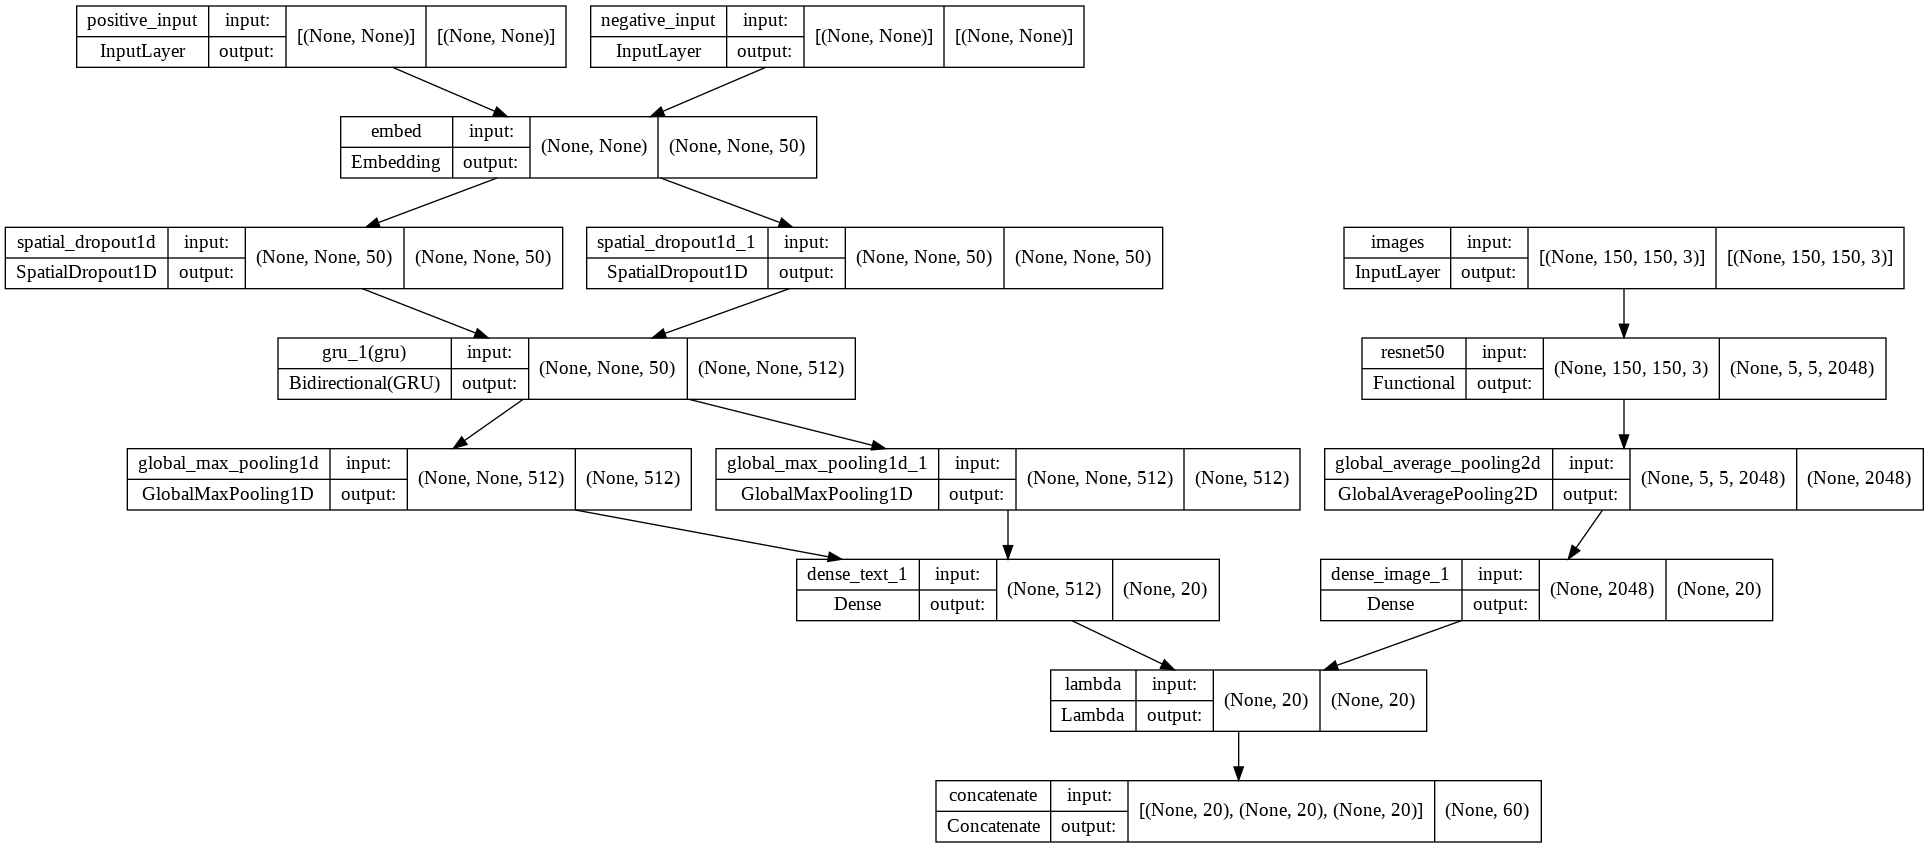

In [ ]:
#Model visulaization
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint
#Steps per epoch calculation
train_per_epochs=len(train_images_list)//batch_size
test_per_epochs=len(test_images_list)//batch_size

#model checkpoint 
file_path='/content/training_weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,save_weights_only=True, mode='min'\
                             ,save_best_only=True)

print(train_per_epochs,test_per_epochs)

624 69


In [ ]:
model.fit(train_data,steps_per_epoch=train_per_epochs,validation_steps=test_per_epochs,validation_data=test_data,epochs=30,callbacks=[checkpoint])

In [ ]:
def freeze_layers(model):
    for i in model.layers:
        i.trainable = True
        if isinstance(i, Model):
            freeze_layers(i)
    return model

model_weights='final_trained.h5'
model=freeze_layers(model)
model.save_weights(model_weights)

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
'''In this script we are creating a representation.csv file 
where we are storing all the vector representation of Image
and their captions'''

def chunker(seq,size):
  return (seq[i:i+size] for i in range(0,len(seq),size))

def text_preprocessing(sentences):
  #print(dir(sentences))
  sentences=BeautifulSoup(sentences,'lxml').get_text()
  return re.sub('[%s]+'%re.escape(string.punctuation),' ',sentences)

def read_txt(path):
  if os.path.isfile(path):
    with open(path,'r') as f:
      txt=f.read()
      txt=text_preprocessing(txt)
      f.close()
    return txt
  else:
    raise FileExistsError("It doesn't exist")



'''Very Important point to be Noted while importing the model saved before should be in the same state when it was save
(i.e) So it is better to make trainable layer training all set to true or false while importing the model.
Else it will throw an error of axes don't match 
So using freeze layer to freeze all the trainable layer'''



#intializing the text embedding model
#Intializing the image embedding model



vocabulary=json.load(open(vocab_mapping,'r'))

#Intialzing the text model with trained weights
t_model=text_model(vocab_size=len(vocabulary))
#t_model=freeze_layers(t_model)
t_model.load_weights(model_weights,by_name=True)

#Intialzing the Image model with trained weights
i_model=image_model()
#i_model=freeze_layers(i_model)
i_model.load_weights(model_weights,by_name=True)


train_images_path,train_caption_path=train_images_list,train_caption_list

image_encoded_vector=[]
text_encode_vector=[]

if not vectorizer.is_adapted:
    if vocabulary is not None:
      vectorizer.set_vocabulary(vocabulary)
    else:
      raise FileExistsError("Please make sure Vocabulary exists")

  

for img_paths,caption_paths in zip(chunker(train_images_path,512),chunker(train_caption_path,512)):
  imgs=np.array([image_loading(p) for p in img_paths])
  captions=[read_txt(p) for p in caption_paths]
  
  captions_vec=vectorizer(captions).numpy()
  #Now we will predict the encoding
  print(imgs.shape)
  #Images  and Catptions should be In batches as keras predict only in batches

  image_embedding=i_model.predict(imgs)
  text_embedding=t_model.predict(captions_vec)

  df_dict=dict({'image_list':img_paths,'captions':captions,'image_embedding':image_embedding.tolist(),\
        'text_embedding':text_embedding.tolist()})
  df=pd.DataFrame(df_dict)
  df.to_csv('representation_images.csv',mode='a',index=False,header=False)

NameError: ignored

In [ ]:
from numpy.lib.shape_base import expand_dims
from sklearn.neighbors import NearestNeighbors
from ast import literal_eval
import pickle
import json
#intializing the text embedding model
#Intializing the image embedding model

'''Very Important point to be Noted while importing the model saved before should be in the same state when it was save
(i.e) So it is better to make trainable layer training all set to true or false while importing the model.
Else it will throw an error of axes don't match'''


vocabulary=json.load(open(vocab_mapping,'r'))

nn_model='/content/drive/MyDrive/fashion_model/nn_model.pkl'

t_model=text_model(vocab_size=len(vocabulary))
#t_model=freeze_layers(t_model)
t_model.load_weights(model_weights,by_name=True)


i_model=image_model()
#i_model=freeze_layers(i_model)
i_model.load_weights(model_weights,by_name=True)

#Training a nearest neigbour model
data=pd.read_csv(img_repr,header=None,names=['image_list','captions','image_embedding','text_embedding'],\
                 converters={'image_embedding':literal_eval})

nn=NearestNeighbors(n_neighbors=8,n_jobs=-1)
nn.fit(data['image_embedding'].tolist())

pickle.dump(nn,open(nn_model,'wb'),)


def seach_by_word(word,t_model,nearest_neigbour,vectorizer,file_name=None):
  #i_model should be an instanec of Model
  assert isinstance(nearest_neigbour,sklearn.neighbors.NearestNeighbors)
  #t_model should be an instance of Model
  
  assert isinstance(t_model,keras.Model)
  #vectorzer should be instance of Textvectorizer

  assert isinstance(vectorizer,keras.layers.TextVectorization)


  if not vectorizer.is_adapted:
    if os.path.isfile(vocab_mapping):
      vocabulary=json.load(open(vocab_mapping,'r'))
      vectorizer.set_vocabulary(vocabulary)
    else:
      raise FileExistsError('Please created a mapping.json in this directory')
  
  label_word=vectorizer([word]).numpy()
  text_repr=t_model.predict(label_word)
  #now we have text repr

  #Now we will use the nearest neigbour to obtain the near search queries
  indices=nearest_neigbour.kneighbors(text_repr,n_neighbors=8,return_distance=False)
  #We are getting 8 neibours
  images=data.loc[indices[0]]['image_list'].tolist()
  plt.figure(figsize=(20,20))
  for i in range(len(indices[0])):
    plt.subplot(4,2,i+1)
    plt.imshow(image_loading(images[i],False,[300,300]))
    plt.title("Similar image %s" % i)
    plt.xticks([])
    plt.yticks([])
  if file_name is not None:
    plt.savefig(str(file_name),dpi=200)

  plt.show()

def search_by_image(image_path,i_model,nearest_neigbour,file_name=None):
  
  assert isinstance(nearest_neigbour,sklearn.neighbors.NearestNeighbors)
  #query Image shape should be equal to that of i_model.input

  image=image_loading(image_path,True)

  assert image.shape==i_model.inputs[0].shape[-3:]

  img_embedding=i_model.predict(tf.expand_dims(image,axis=0))

  #After getting the Image embedding i.e (batch_size,embedding_size)

  idx=nearest_neigbour.kneighbors(img_embedding,n_neighbors=8,return_distance=False)

  similar_image_path=data.iloc[idx[0]]['image_list'].tolist()

  #ploting Query and Similar Image
  plt.figure(figsize=(20,20))

  for i in range(len(similar_image_path)):
    plt.subplot(2,4,i+1)
    if i==0:
      plt.imshow(image_loading(image_path,False,[300,300]))
      plt.title('Query Image')
    else:
      plt.imshow(image_loading(similar_image_path[i],False,[300,300]))
      plt.title('Similary image %s' % (i))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
  if file_name is not None:
    plt.savefig(str(file_name),dpi=200)
  plt.show()

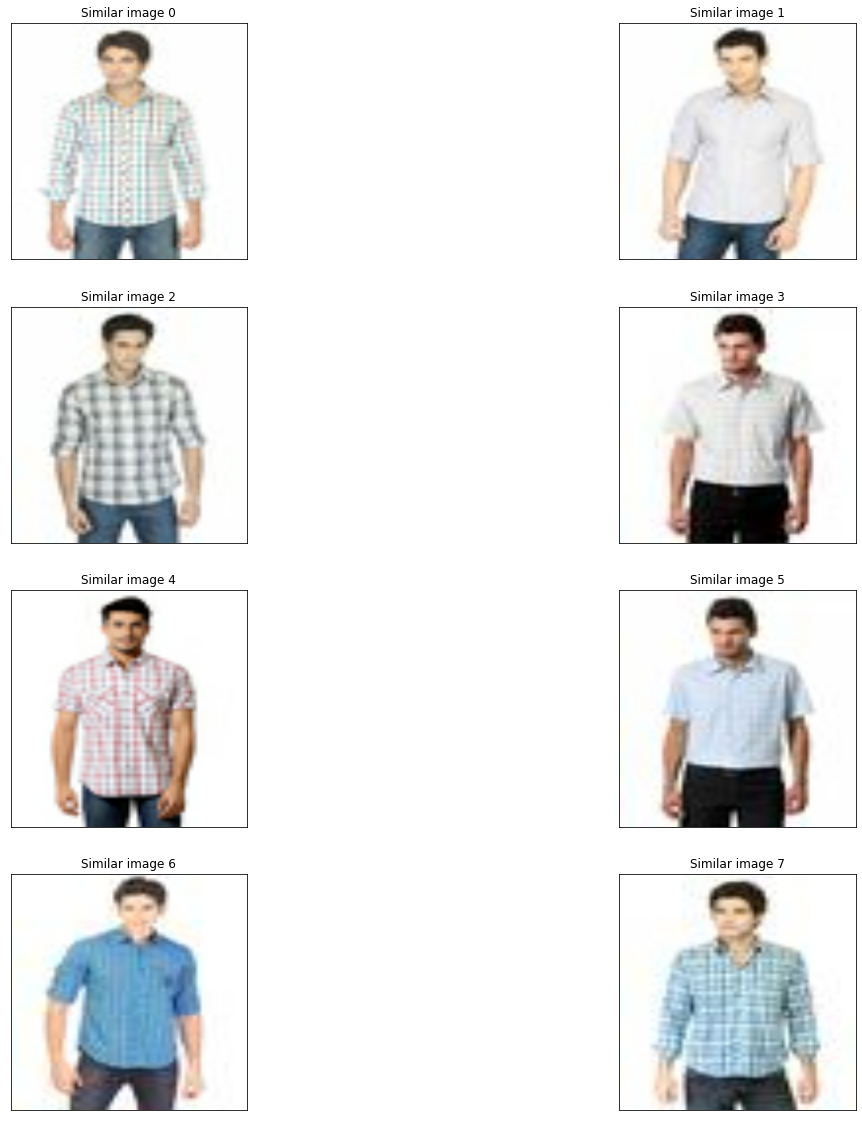

In [ ]:
#testing the trained model on using search by keyword
seach_by_word("Mens check shirt",t_model,nn,keras.layers.TextVectorization(output_sequence_length=10),'search_by_word.jpg')

In [ ]:
import sklearn
#testing the keyword using search by Image
search_by_image('/content/myntradataset/images/10089.jpg',i_model,nn,'search_by_image.jpg')